In [0]:
from sklearn import datasets
import numpy as np
import random
import matplotlib.pyplot as plt
import tqdm
import itertools
from collections import Counter

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch.autograd import Variable
import torch.utils.data

In [5]:
import tensorflow_datasets as tfds 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'mnli_mismatched', 'mnli_matched', 'qnli', 'rte', 'wnli']

['cola',
 'sst2',
 'mrpc',
 'qqp',
 'stsb',
 'mnli',
 'mnli_mismatched',
 'mnli_matched',
 'qnli',
 'rte',
 'wnli']

In [7]:
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
from zipfile import ZipFile
with ZipFile('glove.840B.300d.zip','r') as f:
  f.extractall()
  
!rm -rf glove.840B.300d.zip

embedding_model = {}
with open('glove.840B.300d.txt','r',encoding='utf-8') as f1:
  for line in f1.readlines():
    words = line.split(' ')
    word = words[0]
    embedding_vec = np.asarray(words[1:],dtype='float32')
    embedding_model[word] = embedding_vec

--2019-10-12 05:57:22--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2019-10-12 05:57:22--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  2.00MB/s    in 16m 55s 

2019-10-12 06:14:18 (2.05 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]



In [0]:
def preprocess(text):
  text = re.sub(r"it\'s","it is",str(text))
  text = re.sub(r"i\'d","i would",str(text))
  text = re.sub(r"don\'t","do not",str(text))
  text = re.sub(r"he\'s","he is",str(text))
  text = re.sub(r"there\'s","there is",str(text))
  text = re.sub(r"that\'s","that is",str(text))
  text = re.sub(r"can\'t", "can not", text)
  text = re.sub(r"cannot", "can not ", text)
  text = re.sub(r"what\'s", "what is", text)
  text = re.sub(r"What\'s", "what is", text)
  text = re.sub(r"\'ve ", " have ", text)
  text = re.sub(r"n\'t", " not ", text)
  text = re.sub(r"i\'m", "i am ", text)
  text = re.sub(r"I\'m", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'s"," is",text)
  text = re.sub(r"[^a-zA-Z0-9]"," ",str(text))
  sents = text.split()
  return " ".join(word.lower() for word in sents)

In [0]:
def read(numpT):
  data = list(numpT)
  sentences = [i["sentence"] for i in data]
  labels = [i["label"] for i in data]
  sentences = [str(i)[2:-1] for i in sentences]
  return sentences,labels

# SST2 
Binary Sentiment Analysis

In [10]:
train_ds = tfds.load('glue/sst2')
numpy_ds = tfds.as_numpy(train_ds)


train_sentences, train_labels = read(numpy_ds["train"])
test_sentences, test_labels = read(numpy_ds["test"])
val_sentences, val_labels = read(numpy_ds["validation"])

print("T",np.mean([len(i.split(" ")) for i in train_sentences]))

len(train_sentences),len(test_sentences),len(val_sentences), Counter(train_labels)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/0.0.2. Subsequent calls will reuse this data.
T 10.409553222765


(67349, 1821, 872, Counter({0: 29780, 1: 37569}))

In [11]:
Counter(train_labels), Counter(test_labels), Counter(val_labels)

(Counter({0: 29780, 1: 37569}), Counter({-1: 1821}), Counter({0: 428, 1: 444}))

In [12]:
T=15
max_words=2000
number_filters=50

tok=Tokenizer(num_words=max_words)
tok.fit_on_texts(train_sentences)
word_index = tok.word_index

train_sequences = tok.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=T)

val_sequences = tok.texts_to_sequences(val_sentences)
val_sequences = pad_sequences(val_sequences, maxlen=T)
dim=300
unknown=[]
embedding_matrix = torch.zeros((len(word_index) + 1, dim))
for word, i in word_index.items():
    if word not in embedding_model:
        unknown.append(word)
        embedding_matrix[i] = torch.as_tensor(embedding_model["unk"])
    else:
        embedding_matrix[i] = torch.as_tensor(embedding_model[word])
vocab_size,embedding_dim=embedding_matrix.shape

print("embedding_matrix.shape",embedding_matrix.shape)

tensor_train_sequences = Variable(torch.tensor(train_sequences).long())# Train Sequences long 
tensor_train_labels = Variable(torch.tensor(train_labels).long())# Label->Long

tensor_val_sequences = Variable(torch.tensor(val_sequences).long())# Train Sequences long 
tensor_val_labels = Variable(torch.tensor(val_labels).long())# Label->Long

print("tensor_train_sequences.shape",tensor_train_sequences.shape)


embedding_matrix.shape torch.Size([13839, 300])
tensor_train_sequences.shape torch.Size([67349, 15])


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) #https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/14

def accuracy(tensor_seq,tensor_lab):
  pred=model(tensor_seq).squeeze()
  return torch.sum(tensor_lab == torch.round(pred).long())*100.0/tensor_lab.shape[0]


class CNN(nn.Module):
    def __init__(self,embedding_matrix,T):
      super(CNN, self).__init__()
      self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
      self.T = T
      self.pretrained_embedding = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)
      #self.lstm_layer = nn.LSTM(embedding_dim,50,num_layers=1,batch_first=True)
      self.dropout = nn.Dropout(0.5)
      
      self.con1 = nn.Conv1d(embedding_dim,number_filters,kernel_size=3)
      self.maxp1 = nn.MaxPool1d(T-2)# beacuse kernel size is 3
      
      self.con2 = nn.Conv1d(embedding_dim,number_filters,kernel_size=4)
      self.maxp2 = nn.MaxPool1d(T-3)
      
      self.con3 = nn.Conv1d(embedding_dim,number_filters,kernel_size=5)
      self.maxp3 = nn.MaxPool1d(T-4)
      
      self.fc = nn.Linear(3*number_filters, 1)
    def forward(self,x):
      x=self.embedding_layer(x) # shape -> bs x T x d
      x = x.transpose(1,2) # shape -> bs x d x T
     
      x1=F.relu(self.con1(x))
      x1=self.maxp1(x1)
      x1=x1.flatten(start_dim=1)
      #x1=x1.reshape(x1.shape[0],-1)

      x2=F.relu(self.con2(x))
      x2=self.maxp2(x2)
      x2=x2.flatten(start_dim=1)
      
      x3=F.relu(self.con3(x))
      x3=self.maxp3(x3)
      x3=x3.flatten(start_dim=1)
      
      x=torch.cat([x1,x2,x3],dim=1)
      x=self.dropout(x)
      x=self.fc(x)
      y=torch.sigmoid(x)
      #y1,y2=self.lstm_layer(x,None)
      return y

In [0]:
model=CNN(embedding_matrix,T)

In [15]:
print(count_parameters(model))

dataloader = torch.utils.data.DataLoader(list(zip(tensor_train_sequences,tensor_train_labels)),batch_size=150)

batch,_ = next(iter(dataloader))
print("Outputshape",(model(batch)).shape)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#loss_fun = nn.NLLLoss() #ONLY if u use F.log_softnax
loss_fun = nn.BCELoss() #ONLY if u use F.sigmoid

4332001
Outputshape torch.Size([150, 1])


In [17]:
tensor_val_sequences.shape,tensor_val_labels.shape

(torch.Size([872, 15]), torch.Size([872]))

In [18]:
epochs=3
loss_list=[]
acc_list=[]
val_list=[]
for epoch in range(epochs):
    temp1=[]
    temp2=[]
    temp3=[]
    for data,target in dataloader:
        optimizer.zero_grad()
        y_pred = model(data).squeeze()
        loss = loss_fun(y_pred, target.float())
        loss.backward()
        optimizer.step()
        temp1.append(loss.data)
        acc = torch.sum(target == torch.round(y_pred).long())*100.0/target.shape[0]
        temp2.append(acc)
        temp3.append(accuracy(tensor_val_sequences,tensor_val_labels))
    print("Epoch Number",epoch,"Loss",np.mean(temp1),"train_acc",np.mean(temp2),"val_acc",np.mean(temp3))
    loss_list.append(np.mean(temp1))
    acc_list.append(np.mean(temp2))    
    val_list.append(np.mean(temp3))

Epoch Number 0 Loss 0.6631961 train_acc 59.10022271714922 val_acc 56.351893095768375
Epoch Number 1 Loss 0.58827156 train_acc 67.46102449888642 val_acc 63.060133630289535
Epoch Number 2 Loss 0.52567804 train_acc 72.42093541202672 val_acc 65.97104677060133


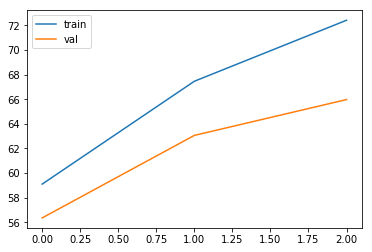

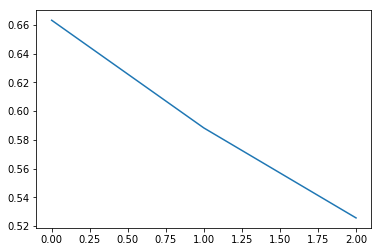

In [21]:
plt.plot(acc_list,label="train")
plt.plot(val_list,label="val")
plt.legend()
plt.show()
plt.plot(loss_list)
plt.show()

# CoLA
Linguisitic Acceptability of Sentences

In [22]:
train_ds = tfds.load('glue/cola')
numpy_ds = tfds.as_numpy(train_ds)

train_sentences, train_labels = read(numpy_ds["train"])
test_sentences, test_labels = read(numpy_ds["test"])
val_sentences, val_labels = read(numpy_ds["validation"])

print("T",np.mean([len(i.split(" ")) for i in train_sentences]))

len(train_sentences),len(test_sentences),len(val_sentences), Counter(train_labels)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/0.0.2. Subsequent calls will reuse this data.
T 7.696409776634312


(8551, 1063, 1043, Counter({0: 2528, 1: 6023}))

In [23]:
Counter(train_labels), Counter(test_labels), Counter(val_labels)

(Counter({0: 2528, 1: 6023}), Counter({-1: 1063}), Counter({0: 322, 1: 721}))

In [24]:
T=15
max_words=2000
number_filters=50

tok=Tokenizer(num_words=max_words)
tok.fit_on_texts(train_sentences)
word_index = tok.word_index

train_sequences = tok.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=T)

val_sequences = tok.texts_to_sequences(val_sentences)
val_sequences = pad_sequences(val_sequences, maxlen=T)

dim=300
unknown=[]
embedding_matrix = torch.zeros((len(word_index) + 1, dim))
for word, i in word_index.items():
    if word not in embedding_model:
        unknown.append(word)
        embedding_matrix[i] = torch.as_tensor(embedding_model["unk"])
    else:
        embedding_matrix[i] = torch.as_tensor(embedding_model[word])
vocab_size,embedding_dim=embedding_matrix.shape

print("embedding_matrix.shape",embedding_matrix.shape)
print("tensor_train_sequences.shape",tensor_train_sequences.shape)

tensor_train_sequences = Variable(torch.tensor(train_sequences).long())# Train Sequences long 
tensor_train_labels = Variable(torch.tensor(train_labels).long())# Label->Long

tensor_val_sequences = Variable(torch.tensor(val_sequences).long())# Train Sequences long 
tensor_val_labels = Variable(torch.tensor(val_labels).long())# Label->Long

embedding_matrix.shape torch.Size([5528, 300])
tensor_train_sequences.shape torch.Size([67349, 15])


In [26]:
model = CNN(embedding_matrix,T)
print(count_parameters(model))
dataloader = torch.utils.data.DataLoader(list(zip(tensor_train_sequences,tensor_train_labels)),batch_size=150)

batch,_ = next(iter(dataloader))
print("Outputshape",(model(batch)).shape)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#loss_fun = nn.NLLLoss() #ONLY if u use F.log_softnax
loss_fun = nn.BCELoss() #ONLY if u use F.sigmoid

1838701
Outputshape torch.Size([150, 1])


In [27]:
epochs=10
loss_list=[]
acc_list=[]
val_list=[]
for epoch in range(epochs):
    temp1=[]
    temp2=[]
    temp3=[]
    for data,target in dataloader:
        optimizer.zero_grad()
        y_pred = model(data).squeeze()
        loss = loss_fun(y_pred, target.float())
        loss.backward()
        optimizer.step()
        temp1.append(loss.data)
        acc = torch.sum(target == torch.round(y_pred).long())*100.0/target.shape[0]
        temp2.append(acc)
        temp3.append(accuracy(tensor_val_sequences,tensor_val_labels))
    print("Epoch Number",epoch,"Loss",np.mean(temp1),"train_acc",np.mean(temp2),"val_acc",np.mean(temp3))
    loss_list.append(np.mean(temp1))
    acc_list.append(np.mean(temp2))    
    val_list.append(np.mean(temp3))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch Number 0 Loss 0.6469906 train_acc 67.98275862068965 val_acc 66.60344827586206
Epoch Number 1 Loss 0.6060159 train_acc 70.37931034482759 val_acc 68.3103448275862
Epoch Number 2 Loss 0.59442306 train_acc 70.29310344827586 val_acc 68.39655172413794
Epoch Number 3 Loss 0.5860068 train_acc 70.63793103448276 val_acc 68.41379310344827
Epoch Number 4 Loss 0.5783829 train_acc 70.98275862068965 val_acc 68.43103448275862
Epoch Number 5 Loss 0.5738952 train_acc 71.1896551724138 val_acc 68.22413793103448
Epoch Number 6 Loss 0.5620411 train_acc 71.27586206896552 val_acc 68.22413793103448
Epoch Number 7 Loss 0.55329156 train_acc 72.08620689655173 val_acc 67.82758620689656
Epoch Number 8 Loss 0.54361475 train_acc 72.74137931034483 val_acc 67.94827586206897
Epoch Number 9 Loss 0.5340296 train_acc 72.75862068965517 val_acc 67.74137931034483


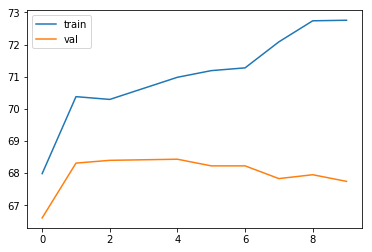

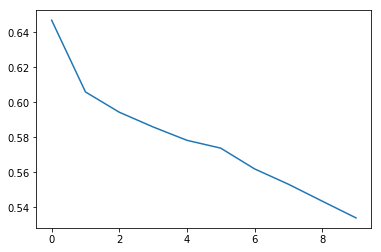

In [28]:
plt.plot(acc_list,label="train")
plt.plot(val_list,label="val")
plt.legend()
plt.show()
plt.plot(loss_list)
plt.show()

#MRPC
Binary Sentence Similarity

In [0]:
def read_pair(numpT):
  data = list(numpT)
  sentences1 = [i["sentence1"] for i in data]
  sentences2 = [i["sentence2"] for i in data]
  labels = [i["label"] for i in data]
  sentences1 = [str(i)[2:-1] for i in sentences1]
  sentences2 = [str(i)[2:-1] for i in sentences2]
  return sentences1,sentences2,labels

In [30]:
train_ds = tfds.load('glue/mrpc')
numpy_ds = tfds.as_numpy(train_ds)

train_sentences1,train_sentences2, train_labels = read_pair(numpy_ds["train"])
val_sentences1,val_sentences2, val_labels = read_pair(numpy_ds["validation"])

print("T1,T2",np.mean([len(i.split(" ")) for i in train_sentences1]),np.mean([len(i.split(" ")) for i in train_sentences2]))

len(train_sentences1),len(train_sentences2),len(val_sentences1),len(val_sentences2), Counter(train_labels)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/0.0.2. Subsequent calls will reuse this data.
T1,T2 21.942748091603054 21.946564885496183


(3668, 3668, 408, 408, Counter({0: 1194, 1: 2474}))

In [31]:
T=40
max_words=2000
number_filters=50

tok=Tokenizer(num_words=max_words)
tok.fit_on_texts(train_sentences1+train_sentences2)
word_index = tok.word_index

train_sequences1 = pad_sequences(tok.texts_to_sequences(train_sentences1),maxlen=T)
train_sequences2 = pad_sequences(tok.texts_to_sequences(train_sentences2),maxlen=T)

val_sequences1 = pad_sequences(tok.texts_to_sequences(val_sentences1), maxlen=T)
val_sequences2 = pad_sequences(tok.texts_to_sequences(val_sentences2), maxlen=T)


dim=300
unknown=[]
embedding_matrix = torch.zeros((len(word_index) + 1, dim))
for word, i in word_index.items():
    if word not in embedding_model:
        unknown.append(word)
        embedding_matrix[i] = torch.as_tensor(embedding_model["unk"])
    else:
        embedding_matrix[i] = torch.as_tensor(embedding_model[word])
vocab_size,embedding_dim=embedding_matrix.shape

print("embedding_matrix.shape",embedding_matrix.shape)


tensor_train_sequences1 = Variable(torch.tensor(train_sequences1).long())# Train Sequences long 
tensor_train_sequences2 = Variable(torch.tensor(train_sequences2).long())# Train Sequences long 

print("tensor_train_sequences.shape",tensor_train_sequences1.shape,tensor_train_sequences2.shape)
tensor_train_labels = Variable(torch.tensor(train_labels).long())# Label->Long

tensor_val_sequences1 = Variable(torch.tensor(val_sequences1).long())# Train Sequences long 
tensor_val_sequences2 = Variable(torch.tensor(val_sequences2).long())# Train Sequences long 

tensor_val_labels = Variable(torch.tensor(val_labels).long())# Label->Long

embedding_matrix.shape torch.Size([12430, 300])
tensor_train_sequences.shape torch.Size([3668, 40]) torch.Size([3668, 40])


In [0]:
def accuracy_2(tensor_seq1,tensor_seq2,tensor_lab):
  pred=model([tensor_seq1,tensor_seq2]).squeeze()
  return torch.sum(tensor_lab == torch.round(pred).long())*100.0/tensor_lab.shape[0]


class CNN_2sent(nn.Module):
    def __init__(self,embedding_matrix,T):
      super(CNN_2sent, self).__init__()
      self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
      self.T=T
      self.pretrained_embedding = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)
      #self.lstm_layer = nn.LSTM(embedding_dim,50,num_layers=1,batch_first=True)
      self.dropout = nn.Dropout(0.5)
      
      self.con1 = nn.Conv1d(embedding_dim,number_filters,kernel_size=3)
      self.maxp1 = nn.MaxPool1d(2*T-4)# beacuse kernel size is 3
      
      self.con2 = nn.Conv1d(embedding_dim,number_filters,kernel_size=4)
      self.maxp2 = nn.MaxPool1d(2*T-6)
      
      self.con3 = nn.Conv1d(embedding_dim,number_filters,kernel_size=5)
      self.maxp3 = nn.MaxPool1d(2*T-8)
      
      self.fc = nn.Linear(3*number_filters, 1)
    def forward(self,x):
      i1,i2=x
      i1=self.embedding_layer(i1)# shape -> bs x T x d
      i2=self.embedding_layer(i2)# shape -> bs x T x d
      x=torch.cat([i1,i2],dim=1)# shape -> bs x 2T x d
      x = x.transpose(1,2)# shape -> bs x d x 2T
     
      x1=F.relu(self.con1(x))
      x1=self.maxp1(x1)
      x1=x1.flatten(start_dim=1)
      #x1=x1.reshape(x1.shape[0],-1)

      x2=F.relu(self.con2(x))
      x2=self.maxp2(x2)
      x2=x2.flatten(start_dim=1)
      
      x3=F.relu(self.con3(x))
      x3=self.maxp3(x3)
      x3=x3.flatten(start_dim=1)
      
      x=torch.cat([x1,x2,x3],dim=1)
      x=self.dropout(x)
      x=self.fc(x)
      y=torch.sigmoid(x)
      return y

In [36]:
model=CNN_2sent(embedding_matrix,T)
print(count_parameters(model))

dataloader = torch.utils.data.DataLoader(list(zip(tensor_train_sequences1,tensor_train_sequences2,tensor_train_labels)),batch_size=150)

batch1,batch2,batch_label = next(iter(dataloader))

print("Outputshape",(model([batch1,batch2])).shape)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#loss_fun = nn.NLLLoss() #ONLY if u use F.log_softnax
loss_fun = nn.BCELoss() #ONLY if u use torch.sigmoid

3909301
Outputshape torch.Size([150, 1])


In [37]:
epochs=10
loss_list=[]
acc_list=[]
val_list=[]
for epoch in range(epochs):
    temp1=[]#for avg los
    temp2=[]#for avg acc
    temp3=[]#for avg val
    for batch_seq1,batch_seq2,batch_lab in iter(dataloader):
        optimizer.zero_grad()
        y_pred = model([batch_seq1,batch_seq2]).squeeze()
        loss = loss_fun(y_pred, batch_lab.float())
        loss.backward()
        optimizer.step()
        temp1.append(loss.data)
        acc = torch.sum(batch_lab == torch.round(y_pred).long())*100.0/batch_lab.shape[0]
        temp2.append(acc)
        temp3.append(accuracy_2(tensor_val_sequences1,tensor_val_sequences2,tensor_val_labels))
    print("Epoch Number",epoch,"Loss",np.mean(temp1),"train_acc",np.mean(temp2),"val_acc",np.mean(temp3))
    loss_list.append(np.mean(temp1))
    acc_list.append(np.mean(temp2))    
    val_list.append(np.mean(temp3))

Epoch Number 0 Loss 0.7002142 train_acc 61.0 val_acc 62.68
Epoch Number 1 Loss 0.64755464 train_acc 65.52 val_acc 65.84
Epoch Number 2 Loss 0.6233894 train_acc 67.08 val_acc 66.88
Epoch Number 3 Loss 0.6139191 train_acc 67.48 val_acc 67.56
Epoch Number 4 Loss 0.61043537 train_acc 68.2 val_acc 67.52
Epoch Number 5 Loss 0.59238315 train_acc 68.84 val_acc 67.4
Epoch Number 6 Loss 0.5953005 train_acc 69.68 val_acc 67.28
Epoch Number 7 Loss 0.5879797 train_acc 69.44 val_acc 67.56
Epoch Number 8 Loss 0.57754934 train_acc 70.2 val_acc 67.56
Epoch Number 9 Loss 0.5675466 train_acc 71.48 val_acc 67.0


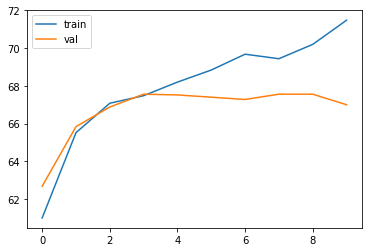

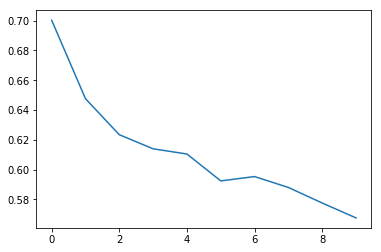

In [38]:
plt.plot(acc_list,label="train")
plt.plot(val_list,label="val")
plt.legend()
plt.show()
plt.plot(loss_list)
plt.show()

# RTE
Binary Classification, Sentence Entailed in Paragraph

In [39]:
train_ds = tfds.load('glue/rte')
numpy_ds = tfds.as_numpy(train_ds)

train_sentences1,train_sentences2, train_labels = read_pair(numpy_ds["train"])
val_sentences1,val_sentences2, val_labels = read_pair(numpy_ds["validation"])

print("T1,T2",np.mean([len(i.split(" ")) for i in train_sentences1]),np.mean([len(i.split(" ")) for i in train_sentences2]))

len(train_sentences1),len(train_sentences2),len(val_sentences1),len(val_sentences2), Counter(train_labels)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/rte/0.0.2. Subsequent calls will reuse this data.
T1,T2 43.63413654618474 8.79437751004016


(2490, 2490, 277, 277, Counter({0: 1249, 1: 1241}))

embedding_matrix.shape torch.Size([15869, 300])
tensor_train_sequences.shape torch.Size([2490, 50]) torch.Size([2490, 50])
4941001
Outputshape torch.Size([150, 1])
Epoch Number 0 Loss 0.763986 train_acc 50.470588235294116 val_acc 49.11764705882353
Epoch Number 1 Loss 0.7367486 train_acc 50.1764705882353 val_acc 49.11764705882353
Epoch Number 2 Loss 0.7077001 train_acc 52.411764705882355 val_acc 50.411764705882355
Epoch Number 3 Loss 0.6899741 train_acc 54.0 val_acc 49.23529411764706
Epoch Number 4 Loss 0.6839885 train_acc 55.470588235294116 val_acc 49.88235294117647
Epoch Number 5 Loss 0.684564 train_acc 54.705882352941174 val_acc 48.94117647058823
Epoch Number 6 Loss 0.6799843 train_acc 55.94117647058823 val_acc 49.76470588235294
Epoch Number 7 Loss 0.6688461 train_acc 59.05882352941177 val_acc 48.76470588235294
Epoch Number 8 Loss 0.66185904 train_acc 59.1764705882353 val_acc 49.05882352941177
Epoch Number 9 Loss 0.66385883 train_acc 59.23529411764706 val_acc 49.64705882352941


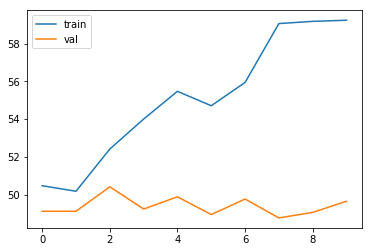

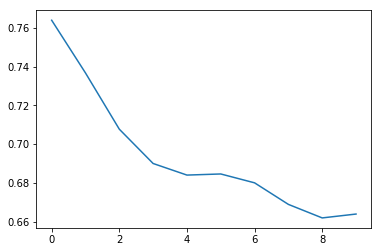

In [40]:
T=50
max_words=2000
number_filters=50

tok=Tokenizer(num_words=max_words)
tok.fit_on_texts(train_sentences1+train_sentences2)
word_index = tok.word_index

train_sequences1 = pad_sequences(tok.texts_to_sequences(train_sentences1),maxlen=T)
train_sequences2 = pad_sequences(tok.texts_to_sequences(train_sentences2),maxlen=T)

val_sequences1 = pad_sequences(tok.texts_to_sequences(val_sentences1), maxlen=T)
val_sequences2 = pad_sequences(tok.texts_to_sequences(val_sentences2), maxlen=T)


dim=300
unknown=[]
embedding_matrix = torch.zeros((len(word_index) + 1, dim))
for word, i in word_index.items():
    if word not in embedding_model:
        unknown.append(word)
        embedding_matrix[i] = torch.as_tensor(embedding_model["unk"])
    else:
        embedding_matrix[i] = torch.as_tensor(embedding_model[word])
vocab_size,embedding_dim=embedding_matrix.shape

print("embedding_matrix.shape",embedding_matrix.shape)


tensor_train_sequences1 = Variable(torch.tensor(train_sequences1).long())# Train Sequences long 
tensor_train_sequences2 = Variable(torch.tensor(train_sequences2).long())# Train Sequences long 

print("tensor_train_sequences.shape",tensor_train_sequences1.shape,tensor_train_sequences2.shape)
tensor_train_labels = Variable(torch.tensor(train_labels).long())# Label->Long

tensor_val_sequences1 = Variable(torch.tensor(val_sequences1).long())# Train Sequences long 
tensor_val_sequences2 = Variable(torch.tensor(val_sequences2).long())# Train Sequences long 

tensor_val_labels = Variable(torch.tensor(val_labels).long())# Label->Long
model=CNN_2sent(embedding_matrix,T)
print(count_parameters(model))

dataloader = torch.utils.data.DataLoader(list(zip(tensor_train_sequences1,tensor_train_sequences2,tensor_train_labels)),batch_size=150)

batch1,batch2,batch_label = next(iter(dataloader))

print("Outputshape",(model([batch1,batch2])).shape)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#loss_fun = nn.NLLLoss() #ONLY if u use F.log_softnax
loss_fun = nn.BCELoss() #ONLY if u use torch.sigmoid
epochs=10
loss_list=[]
acc_list=[]
val_list=[]
for epoch in range(epochs):
    temp1=[]#for avg los
    temp2=[]#for avg acc
    temp3=[]#for avg val
    for batch_seq1,batch_seq2,batch_lab in iter(dataloader):
        optimizer.zero_grad()
        y_pred = model([batch_seq1,batch_seq2]).squeeze()
        loss = loss_fun(y_pred, batch_lab.float())
        loss.backward()
        optimizer.step()
        temp1.append(loss.data)
        acc = torch.sum(batch_lab == torch.round(y_pred).long())*100.0/batch_lab.shape[0]
        temp2.append(acc)
        temp3.append(accuracy_2(tensor_val_sequences1,tensor_val_sequences2,tensor_val_labels))
    print("Epoch Number",epoch,"Loss",np.mean(temp1),"train_acc",np.mean(temp2),"val_acc",np.mean(temp3))
    loss_list.append(np.mean(temp1))
    acc_list.append(np.mean(temp2))    
    val_list.append(np.mean(temp3))
plt.plot(acc_list,label="train")
plt.plot(val_list,label="val")
plt.legend()
plt.show()
plt.plot(loss_list)
plt.show()

# STS-B
Sentence Similarity: 6 Classes

In [74]:
train_ds = tfds.load('glue/stsb')
numpy_ds = tfds.as_numpy(train_ds)

train_sentences1,train_sentences2, train_labels = read_pair(numpy_ds["train"])
val_sentences1,val_sentences2, val_labels = read_pair(numpy_ds["validation"])

print("T1,T2",np.mean([len(i.split(" ")) for i in train_sentences1]),np.mean([len(i.split(" ")) for i in train_sentences2]))

train_labels = np.round(train_labels)
val_labels = np.round(val_labels)

len(train_sentences1),len(train_sentences2),len(val_sentences1),len(val_sentences2), Counter(train_labels)

T1,T2 9.9552965733171 9.94259871281962


(5749,
 5749,
 1500,
 1500,
 Counter({0.0: 615, 1.0: 810, 2.0: 939, 3.0: 1322, 4.0: 1461, 5.0: 602}))

In [0]:
def accuracy_5(tensor_seq1,tensor_seq2,tensor_lab):
  pred=model([tensor_seq1,tensor_seq2]).squeeze()
  return torch.sum(tensor_lab == torch.argmax(pred,dim=-1))*100.0/tensor_lab.shape[0]

class CNN_2sent_5class(nn.Module):
    def __init__(self,embedding_matrix,T):
      super(CNN_2sent_5class, self).__init__()
      self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
      self.T=T
      self.pretrained_embedding = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)
      #self.lstm_layer = nn.LSTM(embedding_dim,50,num_layers=1,batch_first=True)
      self.dropout = nn.Dropout(0.5)
      
      self.con1 = nn.Conv1d(embedding_dim,number_filters,kernel_size=3)
      self.maxp1 = nn.MaxPool1d(2*T-4)# beacuse kernel size is 3
      
      self.con2 = nn.Conv1d(embedding_dim,number_filters,kernel_size=4)
      self.maxp2 = nn.MaxPool1d(2*T-6)
      
      self.con3 = nn.Conv1d(embedding_dim,number_filters,kernel_size=5)
      self.maxp3 = nn.MaxPool1d(2*T-8)
      
      self.fc = nn.Linear(3*number_filters, 6)
    def forward(self,x):
      i1,i2=x
      i1=self.embedding_layer(i1)# shape -> bs x T x d
      i2=self.embedding_layer(i2)# shape -> bs x T x d
      x=torch.cat([i1,i2],dim=1)# shape -> bs x 2T x d
      x = x.transpose(1,2)# shape -> bs x d x 2T
     
      x1=F.relu(self.con1(x))
      x1=self.maxp1(x1)
      x1=x1.flatten(start_dim=1)
      #x1=x1.reshape(x1.shape[0],-1)

      x2=F.relu(self.con2(x))
      x2=self.maxp2(x2)
      x2=x2.flatten(start_dim=1)
      
      x3=F.relu(self.con3(x))
      x3=self.maxp3(x3)
      x3=x3.flatten(start_dim=1)
      
      x=torch.cat([x1,x2,x3],dim=1)
      x=self.dropout(x)
      x=self.fc(x)
      y=F.softmax(x,dim=-1)
      return y

In [99]:
T=15
max_words=2000
number_filters=50

tok=Tokenizer(num_words=max_words)
tok.fit_on_texts(train_sentences1+train_sentences2)
word_index = tok.word_index

train_sequences1 = pad_sequences(tok.texts_to_sequences(train_sentences1),maxlen=T)
train_sequences2 = pad_sequences(tok.texts_to_sequences(train_sentences2),maxlen=T)

val_sequences1 = pad_sequences(tok.texts_to_sequences(val_sentences1), maxlen=T)
val_sequences2 = pad_sequences(tok.texts_to_sequences(val_sentences2), maxlen=T)


dim=300
unknown=[]
embedding_matrix = torch.zeros((len(word_index) + 1, dim))
for word, i in word_index.items():
    if word not in embedding_model:
        unknown.append(word)
        embedding_matrix[i] = torch.as_tensor(embedding_model["unk"])
    else:
        embedding_matrix[i] = torch.as_tensor(embedding_model[word])
vocab_size,embedding_dim=embedding_matrix.shape

print("embedding_matrix.shape",embedding_matrix.shape)


tensor_train_sequences1 = Variable(torch.tensor(train_sequences1).long())# Train Sequences long 
tensor_train_sequences2 = Variable(torch.tensor(train_sequences2).long())# Train Sequences long 

print("tensor_train_sequences.shape",tensor_train_sequences1.shape,tensor_train_sequences2.shape)
tensor_train_labels = Variable(torch.tensor(train_labels).long())# Label->Long

tensor_val_sequences1 = Variable(torch.tensor(val_sequences1).long())# Train Sequences long 
tensor_val_sequences2 = Variable(torch.tensor(val_sequences2).long())# Train Sequences long 

tensor_val_labels = Variable(torch.tensor(val_labels).long())# Label->Long
model=CNN_2sent_5class(embedding_matrix,T)
print(count_parameters(model))

dataloader = torch.utils.data.DataLoader(list(zip(tensor_train_sequences1,tensor_train_sequences2,tensor_train_labels)),batch_size=150)

batch1,batch2,batch_label = next(iter(dataloader))

print("Outputshape",(model([batch1,batch2])).shape)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
loss_fun = nn.CrossEntropyLoss() #ONLY if u use F.softnax

embedding_matrix.shape torch.Size([12036, 300])
tensor_train_sequences.shape torch.Size([5749, 15]) torch.Size([5749, 15])
3791856
Outputshape torch.Size([150, 6])


Epoch Number 0 Loss 1.7916639 train_acc 17.358974358974358 val_acc 16.923076923076923
Epoch Number 1 Loss 1.7521768 train_acc 24.358974358974358 val_acc 19.923076923076923
Epoch Number 2 Loss 1.7490982 train_acc 25.487179487179485 val_acc 20.384615384615383
Epoch Number 3 Loss 1.7424778 train_acc 26.256410256410255 val_acc 20.58974358974359
Epoch Number 4 Loss 1.7417495 train_acc 26.256410256410255 val_acc 20.28205128205128
Epoch Number 5 Loss 1.7404718 train_acc 26.384615384615383 val_acc 20.333333333333332
Epoch Number 6 Loss 1.7344958 train_acc 27.794871794871796 val_acc 20.615384615384617
Epoch Number 7 Loss 1.7325561 train_acc 27.923076923076923 val_acc 20.46153846153846
Epoch Number 8 Loss 1.7279422 train_acc 29.0 val_acc 20.641025641025642
Epoch Number 9 Loss 1.7257904 train_acc 28.641025641025642 val_acc 20.666666666666668


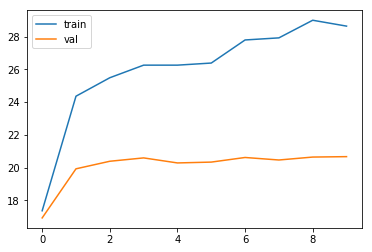

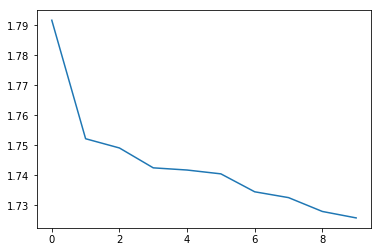

In [100]:
epochs=10
loss_list=[]
acc_list=[]
val_list=[]
for epoch in range(epochs):
    temp1=[]#for avg los
    temp2=[]#for avg acc
    temp3=[]#for avg val
    for batch_seq1,batch_seq2,batch_lab in iter(dataloader):
        optimizer.zero_grad()
        y_pred = model([batch_seq1,batch_seq2])
        #y_pred = torch.argmax(model([batch1,batch2]),dim=-1)
        loss = loss_fun(y_pred, batch_lab.long())
        loss.backward()
        optimizer.step()
        temp1.append(loss.data)
        acc = torch.sum(batch_lab == torch.argmax(y_pred,dim=-1))*100.0/batch_lab.shape[0]
        temp2.append(acc)
        temp3.append(accuracy_5(tensor_val_sequences1,tensor_val_sequences2,tensor_val_labels))
    print("Epoch Number",epoch,"Loss",np.mean(temp1),"train_acc",np.mean(temp2),"val_acc",np.mean(temp3))
    loss_list.append(np.mean(temp1))
    acc_list.append(np.mean(temp2))    
    val_list.append(np.mean(temp3))
plt.plot(acc_list,label="train")
plt.plot(val_list,label="val")
plt.legend()
plt.show()
plt.plot(loss_list)
plt.show()

In [0]:
      #x= x[np.newaxis, :] # shape  bs x T x d -> 1 x bs x T x d same as unsqueeze
      #x = x.transpose(0,1) # shape -> bs x 1 x T x d